In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

In [2]:
np.random.seed(0)

def generate_dataset():
    X = np.random.rand(300, 2)
    y = np.zeros((300, 5))
    
    for i in range(300):
        if X[i, 0] > 0.6:
            y[i, 0] = 1  
        elif X[i, 1] > 0.6:
            y[i, 1] = 1  
        elif X[i, 0] + X[i, 1] < 0.5:
            y[i, 2] = 1  
        elif X[i, 0] > 0.3 and X[i, 1] > 0.3:
            y[i, 3] = 1  
        else:
            y[i, 4] = 1 
            
    return X, y

X, y = generate_dataset()

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [4]:
class NeuralNetwork:
    def __init__(self, input_size, hidden_sizes, output_size):
        self.learning_rate = 0.008
        
        self.W1 = np.random.randn(input_size, hidden_sizes[0])
        self.W2 = np.random.randn(hidden_sizes[0], hidden_sizes[1])
        self.W3 = np.random.randn(hidden_sizes[1], hidden_sizes[2])
        self.W4 = np.random.randn(hidden_sizes[2], output_size)
        
    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))
    
    def sigmoid_derivative(self, x):
        return x * (1 - x)
    
    def softmax(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    def cross_entropy_loss(self, y_true, y_pred):
        return -np.mean(np.sum(y_true * np.log(y_pred + 1e-9), axis=1))
    
    def feedforward(self, X):
        self.Z1 = np.dot(X, self.W1)
        self.A1 = self.sigmoid(self.Z1)
        
        self.Z2 = np.dot(self.A1, self.W2)
        self.A2 = self.sigmoid(self.Z2)
        
        self.Z3 = np.dot(self.A2, self.W3)
        self.A3 = self.sigmoid(self.Z3)
        
        self.Z4 = np.dot(self.A3, self.W4)
        self.A4 = self.softmax(self.Z4)
        
        return self.A4
    
    def backpropagation(self, X, y_true, y_pred):
        output_error = y_pred - y_true
        output_delta = output_error
        
        hidden3_error = np.dot(output_delta, self.W4.T)
        hidden3_delta = hidden3_error * self.sigmoid_derivative(self.A3)
        
        hidden2_error = np.dot(hidden3_delta, self.W3.T)
        hidden2_delta = hidden2_error * self.sigmoid_derivative(self.A2)
        
        hidden1_error = np.dot(hidden2_delta, self.W2.T)
        hidden1_delta = hidden1_error * self.sigmoid_derivative(self.A1)
        
        self.W4 -= self.learning_rate * np.dot(self.A3.T, output_delta)
        self.W3 -= self.learning_rate * np.dot(self.A2.T, hidden3_delta)
        self.W2 -= self.learning_rate * np.dot(self.A1.T, hidden2_delta)
        self.W1 -= self.learning_rate * np.dot(X.T, hidden1_delta)
    
    def train(self, X, y):
        y_pred = self.feedforward(X)
        self.backpropagation(X, y, y_pred)
    
    def predict(self, X):
        y_pred = self.feedforward(X)
        return np.argmax(y_pred, axis=1)


In [5]:
input_size = X_train.shape[1]
hidden_sizes = [16, 16, 16]
output_size = y_train.shape[1]
nn = NeuralNetwork(input_size, hidden_sizes, output_size)

class_losses = {i: [] for i in range(output_size)} 

epochs = 1000

for epoch in range(epochs):
    nn.train(X_train, y_train)
    
    if epoch % 100 == 0:
        y_pred = nn.feedforward(X_train)
        total_loss = nn.cross_entropy_loss(y_train, y_pred)
        
        # Calculate loss for each class separately
        for i in range(output_size):
            class_loss = -np.mean(np.log(y_pred[:, i] + 1e-9) * y_train[:, i])
            class_losses[i].append(class_loss)
        
        print(f"Epoch {epoch}, Total Loss: {total_loss}")

Epoch 0, Total Loss: 1.9190236139367134
Epoch 100, Total Loss: 0.6057746087989447
Epoch 200, Total Loss: 0.4655525689598752
Epoch 300, Total Loss: 0.43657445645153603
Epoch 400, Total Loss: 0.3102301256935221
Epoch 500, Total Loss: 0.26804757224536346
Epoch 600, Total Loss: 0.23703000430090185
Epoch 700, Total Loss: 0.21534967733043683
Epoch 800, Total Loss: 0.1968940417546414
Epoch 900, Total Loss: 0.21588909044135024


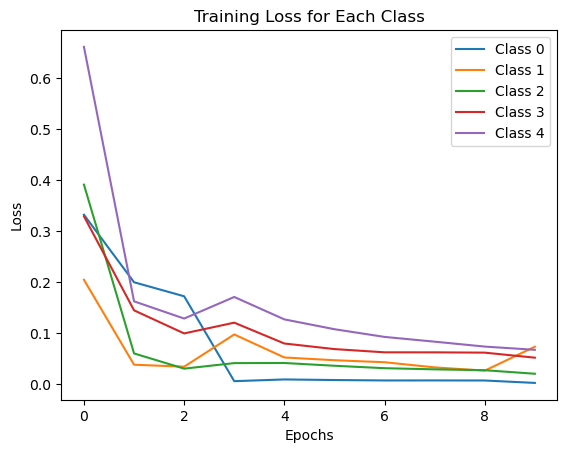

In [6]:
for class_idx in range(output_size):
    plt.plot(class_losses[class_idx], label=f'Class {class_idx}')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss for Each Class')
plt.legend()
plt.show()


In [7]:

y_pred_test = nn.predict(X_test)
y_test_class = np.argmax(y_test, axis=1)


precision_per_class = precision_score(y_test_class, y_pred_test, average=None)
recall_per_class = recall_score(y_test_class, y_pred_test, average=None)
f1_per_class = f1_score(y_test_class, y_pred_test, average=None)


accuracy = accuracy_score(y_test_class, y_pred_test)
precision_overall = precision_score(y_test_class, y_pred_test, average='weighted')
recall_overall = recall_score(y_test_class, y_pred_test, average='weighted')
f1_overall = f1_score(y_test_class, y_pred_test, average='weighted')


num_classes = len(precision_per_class)
for i in range(num_classes):
    print(f"Class {i}:")
    print(f"  Precision: {precision_per_class[i]:.4f}")
    print(f"  Recall: {recall_per_class[i]:.4f}")
    print(f"  F1 Score: {f1_per_class[i]:.4f}")
    print()


print("Overall Metrics:")
print(f"  Accuracy: {accuracy * 100:.2f}%")
print(f"  Precision (Weighted): {precision_overall:.4f}")
print(f"  Recall (Weighted): {recall_overall:.4f}")
print(f"  F1 Score (Weighted): {f1_overall:.4f}")


Class 0:
  Precision: 1.0000
  Recall: 0.9375
  F1 Score: 0.9677

Class 1:
  Precision: 0.8462
  Recall: 1.0000
  F1 Score: 0.9167

Class 2:
  Precision: 1.0000
  Recall: 1.0000
  F1 Score: 1.0000

Class 3:
  Precision: 0.7500
  Recall: 0.7500
  F1 Score: 0.7500

Class 4:
  Precision: 0.8750
  Recall: 0.8750
  F1 Score: 0.8750

Overall Metrics:
  Accuracy: 93.33%
  Precision (Weighted): 0.9385
  Recall (Weighted): 0.9333
  F1 Score (Weighted): 0.9342


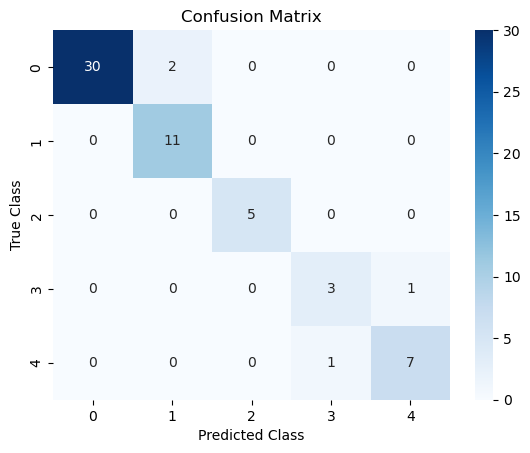

In [8]:
conf_matrix = confusion_matrix(y_test_class, y_pred_test)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()


In [9]:
#  Documentation:
# 1. Three hidden layers were added and updated the output layer to have 5 neurons for 5 classes.
# 2. Softmax was used in the output layer for probability distribution and sigmoid in hidden layers.
# 3. Cross-entropy loss was adapted for better handling of multi-class scenarios.
# 4. The backpropagation algorithm was adapted to handle the updated loss function and multi-class output. 
#    Gradients are computed for each weight based on the errors and propagated backward through the network.
# Faced challenges handling proper multi-class classification but solved it by using softmax and cross entropy loss. 
# 
# Results and Analysis:
# The results are evaluated using the following metrics:
# - Accuracy: Measures the proportion of correctly predicted samples.
# - Precision: Indicates the proportion of true positive predictions out of all positive predictions.
# - Recall: Measures the proportion of true positives out of all actual positives.
# - F1 Score: Provides a balanced measure of precision and recall.
# The confusion matrix is used to visualize the performance of the model across different classes, identifying where the model may be misclassifying samples.
# 
# Observations:
# - Performance was overall good but may vary across classes. 
# - Usage of confusion matrix to identify misclassified classes.
# 
# Conclusion:
# The multi-class classification model performed reasonably well on the synthetic dataset. Key findings include the effectiveness of softmax and cross-entropy in handling multi-class problems.
